In [1]:
"""
Interpretation of topic modeling

- Model: NMF (Tf-idf)
- Data: divide all transcripts into subgroups
- Goal: see the evolution of topic trends

"""

'\nInterpretation of topic modeling\n\n- Model: NMF (Tf-idf)\n- Data: divide all transcripts into subgroups\n- Goal: see the evolution of topic trends\n\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

from wordcloud import WordCloud

from gensim import matutils, models
import scipy.sparse

import re
import string

import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
from clean import *
import importlib

In [3]:
# Let's read in our transcripts and document-term matrix
speech_df_raw = pd.read_pickle('../dump/speech_df')
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
speech_concise = pd.read_pickle('../dump/speech_concise')
# data = pd.read_pickle('../dump/data_dtm_lemma.pkl')
# tdm = data.transpose()
# tdm.shape

## 1. Divide the transcripts base on time
Aim to divied into 5 parts; each ~ 90 speeches.
1. Pre 2003
2. 2003-2009
3. 2009-2012
4. 2012-2015
5. 2015-

In [18]:
# Examine years
sorted_year = speech_df.sort_values('year')
# sorted_year

In [5]:
# Update correct year
sorted_year.loc[440,'year'] = 2015
sorted_year = sorted_year.sort_values('year')

In [6]:
# Count number of speech in each time slot
speech_df_1 = sorted_year[sorted_year.year<2003]
speech_df_2 = sorted_year[(sorted_year.year>= 2003)&(sorted_year.year<2009)]
speech_df_3 = sorted_year[(sorted_year.year>= 2009)&(sorted_year.year<2012)]
speech_df_4 = sorted_year[(sorted_year.year>= 2012)&(sorted_year.year<2015)]
speech_df_5 = sorted_year[sorted_year.year>= 2015]

speech_df_1.shape[0],\
speech_df_2.shape[0],\
speech_df_3.shape[0],\
speech_df_4.shape[0],\
speech_df_5.shape[0],

(87, 90, 94, 101, 69)

## 2. Preparation for topic modeling

In [92]:
def topic_modeling(speech_df_x,column_name,num_topic):
    """
    For a given df and column_name (e.g.:'transcript' for all text, 'nouns' for nouns only),
    return the topic_word dataframe
    
    Method: Tf-idf and NMF
    
    """
    
    # Prepare Tf-idf
    tfidf = TfidfVectorizer()
    csr_mat = tfidf.fit_transform(speech_df_x[column_name])
    doc_word = tfidf_dtm(speech_df_x,column_name)

    # Modeling
    nmf_model = NMF(num_topic, max_iter=1000)
    doc_topic = nmf_model.fit_transform(doc_word)
    doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]

    # Use components in NMF model to find the top 10 words for a given topic
    topics = nmf_model.components_.argsort(axis=1)[:,-1:-21:-1]

    # Create topic_worrd df
    words = doc_word.columns
    topic_words = [[words[index] for index in topic] for topic in topics]
    topic_word_df = pd.DataFrame(topic_words,index=['Topic #' + '{:02d}'.format(i+1) for i in range(num_topic)])
    
    return topic_word_df

In [21]:
# First use the topic model on all transcripts

num_topic = 8
speech_df_x = wash(speech_concise,'transcript').copy()
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic #01,parent,advice,film,story,money,friends,kid,person,movie,play
Topic #02,women,workers,voice,genius,floor,success,conversation,mother,workforce,skirt
Topic #03,generation,country,government,community,education,history,nation,nations,century,freedom
Topic #04,company,business,journey,career,passion,technology,selfconfidence,leadership,confidence,engineer
Topic #05,fear,generosity,hearts,drum,heart,truth,moment,mind,practice,death
Topic #06,team,tennis,sport,game,player,coach,baseball,dream,percent,soccer
Topic #07,art,science,book,paint,artist,shell,scientist,course,botany,genus
Topic #08,dream,education,mother,father,degree,family,thank,sister,community,value


In [59]:
# # Pickle
# # This it the first topic modeling used in slides

# topic_df.to_pickle('../dump2/topic_df_8_NMF')

Interpretation of topics:

1. Family, friends & advice
2. Women's voice
3. New generation & the nation
4. Technology & business
5. Fear & truth
6. Sportsmanship
7. Art & science
8. Dream

In [93]:
# Trial (added stop words in clean.py)

num_topic = 8
speech_df_x = wash(speech_concise,'transcript').copy()
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic #01,advice,film,story,money,kid,movie,person,play,man,moment,actor,year,point,night,home,room,days,course,talk,phone
Topic #02,women,workers,voice,genius,floor,success,mother,conversation,workforce,skirt,gender,book,privilege,silence,fact,doors,connection,factory,place,balance
Topic #03,generation,country,government,community,education,history,nation,nations,freedom,century,sense,democracy,challenge,change,society,culture,purpose,percent,future,war
Topic #04,company,business,journey,career,passion,technology,selfconfidence,leadership,confidence,decision,engineer,success,path,law,courage,heart,purpose,ideas,customers,team
Topic #05,fear,generosity,drum,heart,truth,moment,practice,mind,music,failure,death,value,experience,joy,sound,power,virtue,compassion,pain,flow
Topic #06,team,tennis,sport,player,game,coach,baseball,percent,dream,soccer,football,mentor,players,cookie,ball,numberone,friendships,cents,women,match
Topic #07,art,science,book,paint,artist,shell,scientist,botany,course,genus,seashells,perception,species,materials,garden,study,wholebrain,pepper,descriptions,research
Topic #08,dream,education,mother,father,degree,thank,sister,value,community,core,opportunity,speech,advice,share,heart,doctor,student,doctorate,honor,vision


In [96]:
# Find assigned_topic

tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(speech_df_x['nouns'])
doc_word = tfidf_dtm(speech_df_x,'nouns')

# Modeling
nmf_model = NMF(num_topic, max_iter=1000)
doc_topic = nmf_model.fit_transform(doc_word)

# Array of assigned topic
doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]+1

In [97]:
# Create column for topic
speech_df_x['topic'] = doc_assigned_topic

In [209]:
mapping_topic = {'1':'1 Family','2':"2 Women",'3':'3 Nation','4':"4 Tech",
                 '5':"5 Hardship",'6':"6 Sports",'7':"7 Science",'8':"8 Dream"}

In [210]:
# Use text as topic
speech_df_x['TOPIC'] = speech_df_x['topic'].astype(str).map(mapping_topic)

In [223]:
speech_df_x.head()

,speaker,year,school,transcript,transcript_clean,category,age,age_then,age_cat,region,nouns,topic,TOPIC
0,CARLY FIORINA,2000,MIT,like to start my remark this morning with spec...,I'd start remarks morning special thanks sent ...,Tech/Business,66,46,40-50,east,remark morning thank couple weeks speech comme...,8,8 Dream
1,J.K. ROWLING,2008,Harvard University,i have wrack my mind and heart for what i ough...,"EXCERPTS Actually, I wracked mind heart I ough...",Publish,55,43,40-50,east,i mind heart i today i i graduation lessons ye...,5,5 Hardship
2,JEAN ANDREWS,2003,University of Texas at Austin,when invite me to present the commencement add...,\nWhen Dean Rankin invited present commencemen...,Education/Research,97,80,80-90,central,commencement address class graduate i anyone y...,7,7 Science
3,MIKE TOMLIN,2008,Saint Vincent College,some excerpt as find in want to encourage you ...,"Some excerpts Post Gazette:\n\n ""I encourag...",Sport,48,36,30-40,east,excerpt find want preparation game life minute...,6,6 Sports
4,AARON SORKIN,2012,SYRACUSE UNIVERSITY,you very much members of the of members of the...,"Thank much. Madam Chancellor, members Board T...",Publish,59,51,50-60,east,members members faculty administration parent ...,1,1 Family


In [224]:
# # Pickle
# speech_df_x.to_pickle('../dump/speech_topic_NMF')

In [213]:
# speech_df_x.iloc[1].transcript

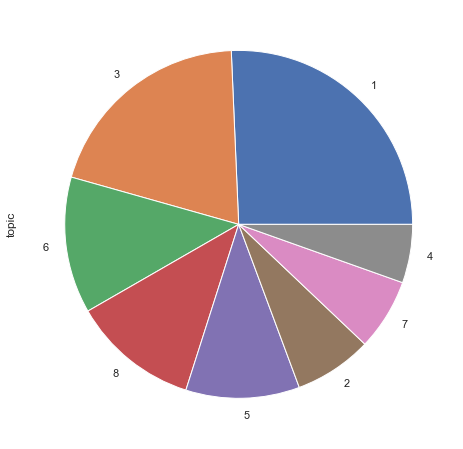

In [214]:
# 8 with speech_concise
# Check topic distribution over time
dist_df = speech_df_x.topic.value_counts()
dist_df.plot.pie(y='topic');

In [28]:
# speech_df_x[speech_df_x.topic == 0].sort_values('year').year.value_counts().sort_index()

In [29]:
topic_year = []
for i in range(num_topic):
    topic_year.append(speech_df_x[speech_df_x.topic == i+1].sort_values('year').year.value_counts().sort_index())

In [30]:
topic_yeat_df = pd.DataFrame(topic_year,index=[i+1 for i in range(num_topic)]).fillna(0)
topic_yeat_df_T = topic_yeat_df.loc[:,2000:].transpose()
topic_yeat_df_T['9']=[0]*topic_yeat_df_T.shape[0]       # just for adjusting the colormap later
# topic_yeat_df_T

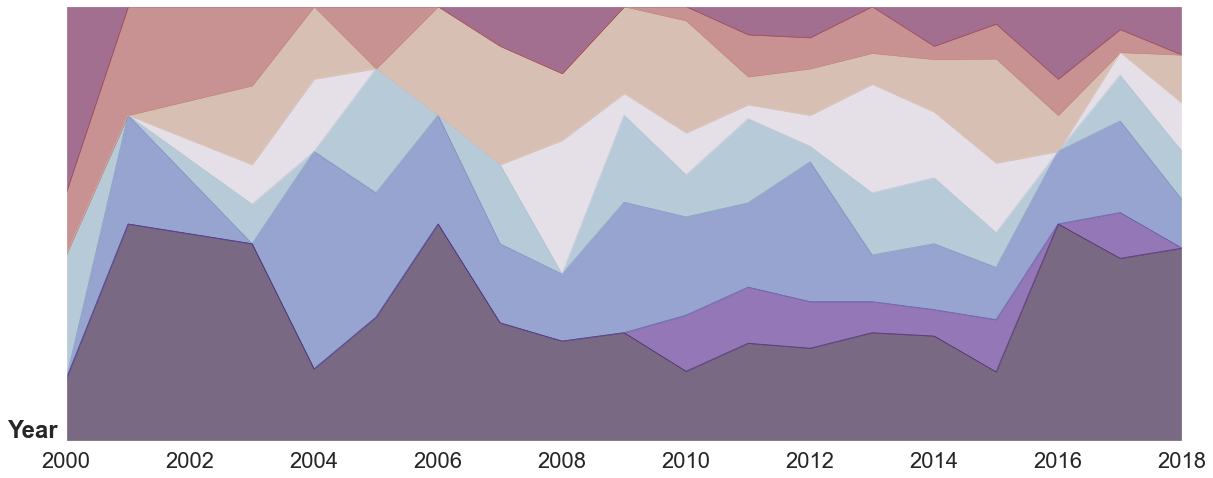

In [54]:
# Full stack area plot

plt.rcParams['figure.figsize']=[20,8]
cmap = plt.get_cmap('twilight_shifted')

df = topic_yeat_df_T.divide(topic_yeat_df_T.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, alpha = 0.6, cmap = cmap,
             linewidth=0.5, legend=False,
            )

ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
# plt.legend(bbox_to_anchor=(1., 1))
plt.ylim(0,1)
ax.grid(False)
ax.axes.yaxis.set_ticks([])
# ax.set_title('Trend of topic over the years',fontsize=28)
ax.set_ylabel('',fontsize=18)
ax.set_xlabel('Year',fontsize=24,fontweight='bold')
plt.xticks(fontsize=22)
plt.yticks(fontsize=14)

ax.xaxis.set_label_coords(-0.03, 0.05)

plt.show()

fig = ax.get_figure()
# fig.savefig('../plot/topic_trend.pdf', bbox_inches='tight', transparent = True)

# 1. Family, friends & advice
# 2. Women's voice
# 3. New generation & the nation
# 4. Dream & value
# 5. Fear & truth
# 6. Sports & team player
# 7. Art & science
# 8. Technology & business

In [ ]:
135, 122, 150
137, 67, 186
158, 181, 219
155, 194, 190
227, 223, 213
214, 188, 159
189, 130, 143
161, 112, 148

In [56]:
import altair as alt
from vega_datasets import data

source = data.unemployment_across_industries.url

alt.Chart(source).mark_area().encode(
    alt.X('yearmonth(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0)
    ),
    alt.Y('sum(count):Q', stack='center', axis=None),
    alt.Color('series:N',
        scale=alt.Scale(scheme='category20b')
    )
).interactive()

alt.Chart(...)

### Examin transcript and interpret results
#### A. In 2004, larger portion for the generation & nation topic (#3)
#### B. in 2008, fear (#5)

In [128]:
# speech_df_x

In [75]:
speech_df_x[(speech_df_x.year == 2008) & (speech_df_x.topic == 5)]

,speaker,year,school,transcript,transcript_clean,category,age,age_then,age_cat,region,nouns,topic
1,J.K. ROWLING,2008,Harvard University,i have wrack my mind and heart for what i ough...,"EXCERPTS Actually, I wracked mind heart I ough...",Publish,55,43,40-50,east,i mind heart i today i i graduation lessons ye...,5
147,JESSICA LANGE,2008,SARAH LAWRENCE COLLEGE,you be our hope so cherish this time in your l...,You hope. So cherish life. Remember are. Becau...,Entertainment,71,59,50-60,east,hope time life power imagination velocity drea...,5
154,JK ROWLING,2008,HARVARD UNIVERSITY,members of the and the of members of the facul...,"President Faust, members Harvard Corporation B...",Publish,55,43,40-50,east,members members faculty parent graduate thing ...,5
163,JOHN MACKEY,2008,BENTLEY COLLEGE,i want to begin by thank for invite me to be w...,"I begin thanking Bentley College’s President, ...",Tech/Business,67,55,50-60,east,i thank today recommend speaker honor occasion...,5


In [78]:
speech_df_x.iloc[163].transcript

'i want to begin by thank for invite me to be with you today and for for recommend me as a speaker to it be a great honor to be with all of you on this special occasion i want to congratulate all of the students who be graduate you have all accomplish something that i never have accomplish in my own life—finishing college in the early s i attend two universities in in and the of in i drop in and out of these two school a half dozen time over a year period pile up about hours in various electives i only take class i be interest in primarily philosophy religion and the humanities to be perfectly honest with you i spend my late teens and very early twenties primarily try to figure out the mean of life or at least the mean of my own life i never take any business class in school and if someone have tell me back then that i be go to become a business entrepreneur when i be and start my own business i would have laugh them out of the room unfortunately i wasnt able to discover the mean of my

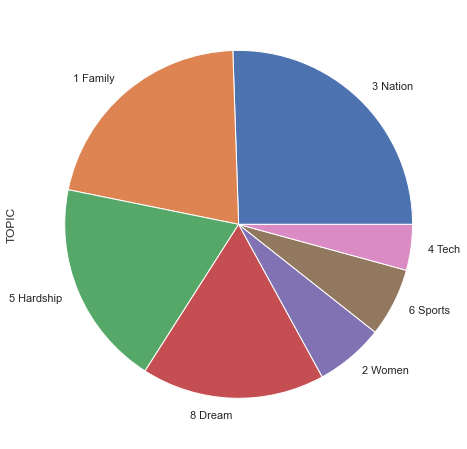

In [215]:
west_topic = speech_df_x[(speech_df_x.region == 'west')].TOPIC.value_counts()
west_topic.plot.pie(y='TOPIC');

In [218]:
west_topic.reset_index().rename(columns={'index':'topic','TOPIC':'count'}).sort_values('topic')

,topic,count
1,1 Family,10
4,2 Women,3
0,3 Nation,12
6,4 Tech,2
2,5 Hardship,9
5,6 Sports,3
3,8 Dream,8


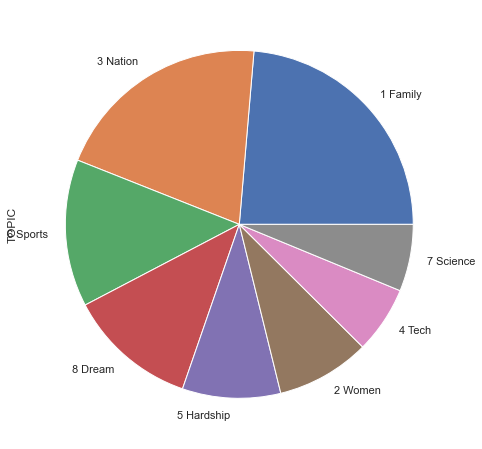

In [219]:
east_topic = pd.DataFrame(speech_df_x[(speech_df_x.region == 'east')].TOPIC.value_counts())
east_topic.plot.pie(y='TOPIC',legend=False);

In [220]:
east_topic.reset_index().rename(columns={'index':'topic','TOPIC':'count'}).sort_values('topic')

,topic,count
0,1 Family,57
5,2 Women,21
1,3 Nation,49
6,4 Tech,15
4,5 Hardship,22
2,6 Sports,33
7,7 Science,15
3,8 Dream,29


In [134]:
# speech_df_x[(speech_df_x.region == 'east')]

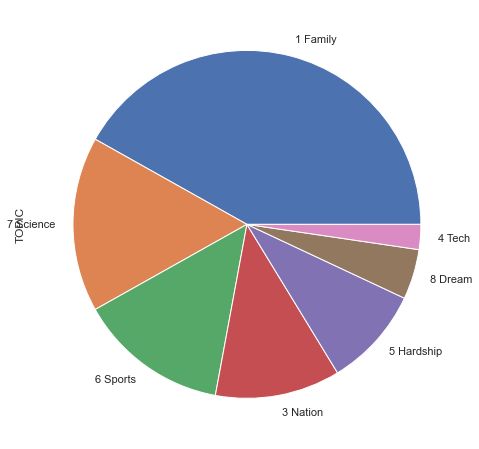

In [221]:
central_topic = speech_df_x[(speech_df_x.region == 'central')].TOPIC.value_counts()
central_topic.plot.pie(y='TOPIC');

In [222]:
central_topic.reset_index().rename(columns={'index':'topic','TOPIC':'count'}).sort_values('topic')

,topic,count
0,1 Family,18
3,3 Nation,5
6,4 Tech,1
4,5 Hardship,4
2,6 Sports,6
1,7 Science,7
5,8 Dream,2


In [130]:
speech_df_x.region.value_counts()

east       241
west        47
central     43
Name: region, dtype: int64

In [100]:
speech_df_x.category.unique()

array(['Tech/Business', 'Publish', 'Education/Research', 'Sport',
       'Entertainment', 'Politics', 'Med/Law', 'Science', 'Art', 'Other'],
      dtype=object)

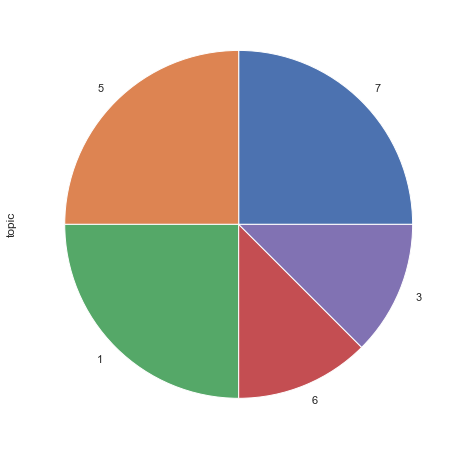

In [114]:
east_topic = speech_df_x[(speech_df_x.category == 'Art')].topic.value_counts()
east_topic.plot.pie(y='topic');

May be interesting ...

* Tech/Business --> Dream/fear,failure/generation
* Publish --> women's voice
* Education/Research --> generation/ art,science / dream
* Sport --> tech,business / sportsmanship / dream
* Entertainment --> sportsmanship / fear
* politics --> generation,nation / dream / sportsmanship
* art --> fear / arts & science / 